In [1]:
import pymc as pm
import arviz as az

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as pt

from thesis_tools.models.frequentist import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Generalised Pareto

In [2]:
# Define the groups and years
groups = ['Group A', 'Group B', 'Group C']

# Define the years for each group, ensuring partial overlap and no gaps within each group
group_years = {
    'Group A': list(range(2000, 2010)),  # 2000-2005
    'Group B': list(range(2003, 2012)),  # 2003-2008
    'Group C': list(range(2007, 2019))   # 2007-2011
}

# Create a list of dictionaries to construct the dataframe
data = []
for group, years in group_years.items():
    for year in years:
        data.append({'group': group, 'year': year})

# Create the dataframe
df = pd.DataFrame(data)

# Set a seed for reproducibility
#np.random.seed(42)

# Generate random normal values for x_1, x_2, and x_3
df['x_1'] = np.random.normal(size=len(df))
df['x_2'] = np.random.normal(size=len(df))
df['x_3'] = np.random.normal(size=len(df))

# # Generate random beta coefficients for each group and each covariate
# beta_x_1 = {group: np.random.normal() for group in groups}
# beta_x_2 = {group: np.random.normal() for group in groups}
# beta_x_3 = {group: np.random.normal() for group in groups}
# make the betas -1, 0, 1
beta_x_1 = {group: 1.0 for group in groups}
beta_x_2 = {group: 0.0 for group in groups}
beta_x_3 = {group: -1.0 for group in groups}


# Add beta coefficients to the dataframe
df['beta_x_1'] = df['group'].map(beta_x_1)
df['beta_x_2'] = df['group'].map(beta_x_2)
df['beta_x_3'] = df['group'].map(beta_x_3)

# Add the sigma column
df['sigma'] = 0.0
for group in groups:
    min_year_index = df[df['group'] == group]['year'].idxmin()
    df.at[min_year_index, 'sigma'] = 1.0

df['log_sigma'] = np.log(df['sigma'])

# Apply the recursion formula
for group in groups:
    group_df = df[df['group'] == group]
    for i in range(1, len(group_df)):
        current_index = group_df.index[i]
        previous_index = group_df.index[i-1]
        log_sigma_t = df.at[previous_index, 'log_sigma']
        x_beta = (df.at[current_index, 'x_1'] * df.at[current_index, 'beta_x_1'] +
                  df.at[current_index, 'x_2'] * df.at[current_index, 'beta_x_2'] +
                  df.at[current_index, 'x_3'] * df.at[current_index, 'beta_x_3'])
        df.at[current_index, 'log_sigma'] = log_sigma_t + x_beta

df['sigma'] = np.exp(df['log_sigma'])

# Generate a vector of random normals with mean 0 and std sigma for each row
def generate_random_normals(row):
    sample_size = np.random.randint(50, 101)  # Random sample size between 50 and 100
    sigma = row['sigma']  # Convert log_sigma back to sigma
    return GeneralisedPareto(mu=1.0, gamma=0.25, sigma=sigma).sample(sample_size)

df['random_normals'] = df.apply(generate_random_normals, axis=1)

/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
import pandas as pd
import numpy as np

# Assuming df is the dataframe we generated previously
# Create the generalized Pareto model
generalised_pareto_model = pm.Model()

with generalised_pareto_model:
    # Define initial sigma for each group
    initial_sigma = {}
    for group in df['group'].unique():
        initial_sigma[group] = pm.Gamma(f'initial_sigma_{group}', alpha=1, beta=1)

    # Define betas for each covariate and each group
    betas = {}
    n_groups = len(df['group'].unique())
    n_covariates = 3 # TODO: Remove hardcoding
    
    betas = {}
    for cov in range(n_covariates):
        beta_variances = pm.Gamma(f'beta_variances_{cov}', alpha=1, beta=1, shape=n_groups)
        beta_cov = pt.diag(beta_variances)

        beta_mu = np.zeros(n_groups)
        betas[cov] = pm.MvNormal(f'betas_{cov}', mu=beta_mu, cov=beta_cov, shape=n_groups)

    # Prepare betas for each group
    group_betas = {group: [] for group in df['group'].unique()}
    for i, group in enumerate(df['group'].unique()):
        for cov in range(n_covariates):
            group_betas[group].append(betas[cov][i])
        group_betas[group] = pt.stack(group_betas[group])

    # Define sigma for each time step and group
    sigma = {group: [initial_sigma[group]] for group in df['group'].unique()}

    for group in df['group'].unique():
        group_df = df[df['group'] == group].reset_index()
        T = len(group_df)
        X = group_df[['x_1', 'x_2', 'x_3']].values
        epsilon_sigma = pm.Gamma(f'epsilon_sigma_{group}', alpha=1, beta=1)
        for t in range(1, T):
            epsilon = pm.Normal(f'epsilon_{group}_{t}', mu=0, sigma=epsilon_sigma)
            sigma[group].append(sigma[group][-1] * pm.math.exp(pm.math.dot(X[t], group_betas[group])) + epsilon)

    # Functions for the custom distribution
    def gpd_logp(value, mu, gamma, sigma):
        if gamma == 0:
            return -np.log(sigma) - (value - mu) / sigma
        else:
            return -np.log(sigma) - (1 + 1 / gamma) * np.log(1 + gamma * (value - mu) / sigma)

    def gpd_random(mu, gamma, sigma, rng=None, size=None):
        # generate uniforms
        u = rng.uniform(size=size)
        if gamma == 0:
            return mu - sigma * np.log(1-u)
        else:
            return mu + sigma * ((1 / (1 - u)**gamma - 1)) / gamma
        
    gammas = {}
    for group in df['group'].unique():
        gammas[group] = pm.Gamma(f'gamma_{group}', alpha=1, beta=1)
    
    mu=1.0

    y_obs = []
    for group in df['group'].unique():
        group_df = df[df['group'] == group].reset_index()
        T = len(group_df)
        for t in range(T):
            y_obs.append(pm.CustomDist(
                f'y_{group}_{t}',
                mu,
                gammas[group],
                sigma[group][t],
                logp=gpd_logp, 
                random=gpd_random,
                observed=group_df.loc[t, 'random_normals'],
            ))

In [4]:
with generalised_pareto_model:
    generalised_pareto_trace = pm.sample(1000, tune=1000, nuts_sampler='nutpie')

/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:379: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:379: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:379: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:379: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/philipphocker/Documents/G

In [5]:
temp = az.summary(generalised_pareto_trace)

In [6]:
temp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_variances_0[0],0.862,0.858,0.003,2.286,0.090,0.064,30.0,56.0,1.08
beta_variances_0[1],1.205,0.903,0.077,2.778,0.031,0.022,859.0,1515.0,1.01
beta_variances_0[2],1.164,0.885,0.124,2.732,0.020,0.014,610.0,1363.0,1.01
beta_variances_0_log__[0],-0.640,1.130,-2.759,1.419,0.223,0.159,30.0,56.0,1.08
beta_variances_0_log__[1],-0.075,0.746,-1.438,1.266,0.026,0.018,859.0,1515.0,1.01
...,...,...,...,...,...,...,...,...,...
initial_sigma_Group A_log__,0.061,0.197,-0.148,0.371,0.091,0.072,6.0,17.0,1.92
initial_sigma_Group B,1.169,0.161,0.892,1.481,0.008,0.006,464.0,1338.0,1.01
initial_sigma_Group B_log__,0.147,0.137,-0.113,0.394,0.007,0.005,464.0,1338.0,1.01
initial_sigma_Group C,1.154,0.120,0.910,1.364,0.003,0.002,1654.0,1424.0,1.01


In [7]:
df

,group,year,x_1,x_2,x_3,beta_x_1,beta_x_2,beta_x_3,sigma,log_sigma,random_normals
0,Group A,2000,0.262216,0.676136,-0.346656,1.0,0.0,-1.0,1.000000,0.000000,"[1.8209276584652274, 1.6907618162211007, 5.348..."
1,Group A,2001,1.484446,0.868504,1.041753,1.0,0.0,-1.0,1.556895,0.442694,"[1.8666673819443003, 4.965972141394033, 1.0732..."
2,Group A,2002,-1.641348,0.431586,-1.430271,1.0,0.0,-1.0,1.260636,0.231616,"[1.6711983180403558, 1.5135548282640066, 1.348..."
3,Group A,2003,-1.519258,-0.017787,-1.112912,1.0,0.0,-1.0,0.839684,-0.174729,"[3.0436031675231274, 1.5204232010380632, 1.008..."
4,Group A,2004,-1.783493,-0.135621,-0.314834,1.0,0.0,-1.0,0.193324,-1.643388,"[1.4332543933494204, 1.2038725133523474, 1.071..."
5,Group A,2005,-0.742207,-0.184700,0.567653,1.0,0.0,-1.0,0.052170,-2.953248,"[1.0511880594287821, 1.0183147825174028, 1.057..."
6,Group A,2006,1.296899,0.540717,0.411242,1.0,0.0,-1.0,0.126490,-2.067592,"[1.0129532004615083, 1.100971857124041, 1.0448..."
7,Group A,2007,0.885302,0.260101,0.039269,1.0,0.0,-1.0,0.294771,-1.221558,"[1.4887394606225492, 1.0518912123387032, 1.466..."
8,Group A,2008,0.378848,-1.680922,0.779242,1.0,0.0,-1.0,0.197513,-1.621952,"[1.0169421089006458, 1.1570089838712212, 1.008..."
9,Group A,2009,-2.590048,-0.026318,2.013881,1.0,0.0,-1.0,0.001978,-6.225881,"[1.0226599874780997, 1.0006648081675211, 1.003..."


/Users/philipphocker/Documents/GitHub/top_wealth_thesis/thesis_venv/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (55), generating only 20 plots
  warnings.warn(


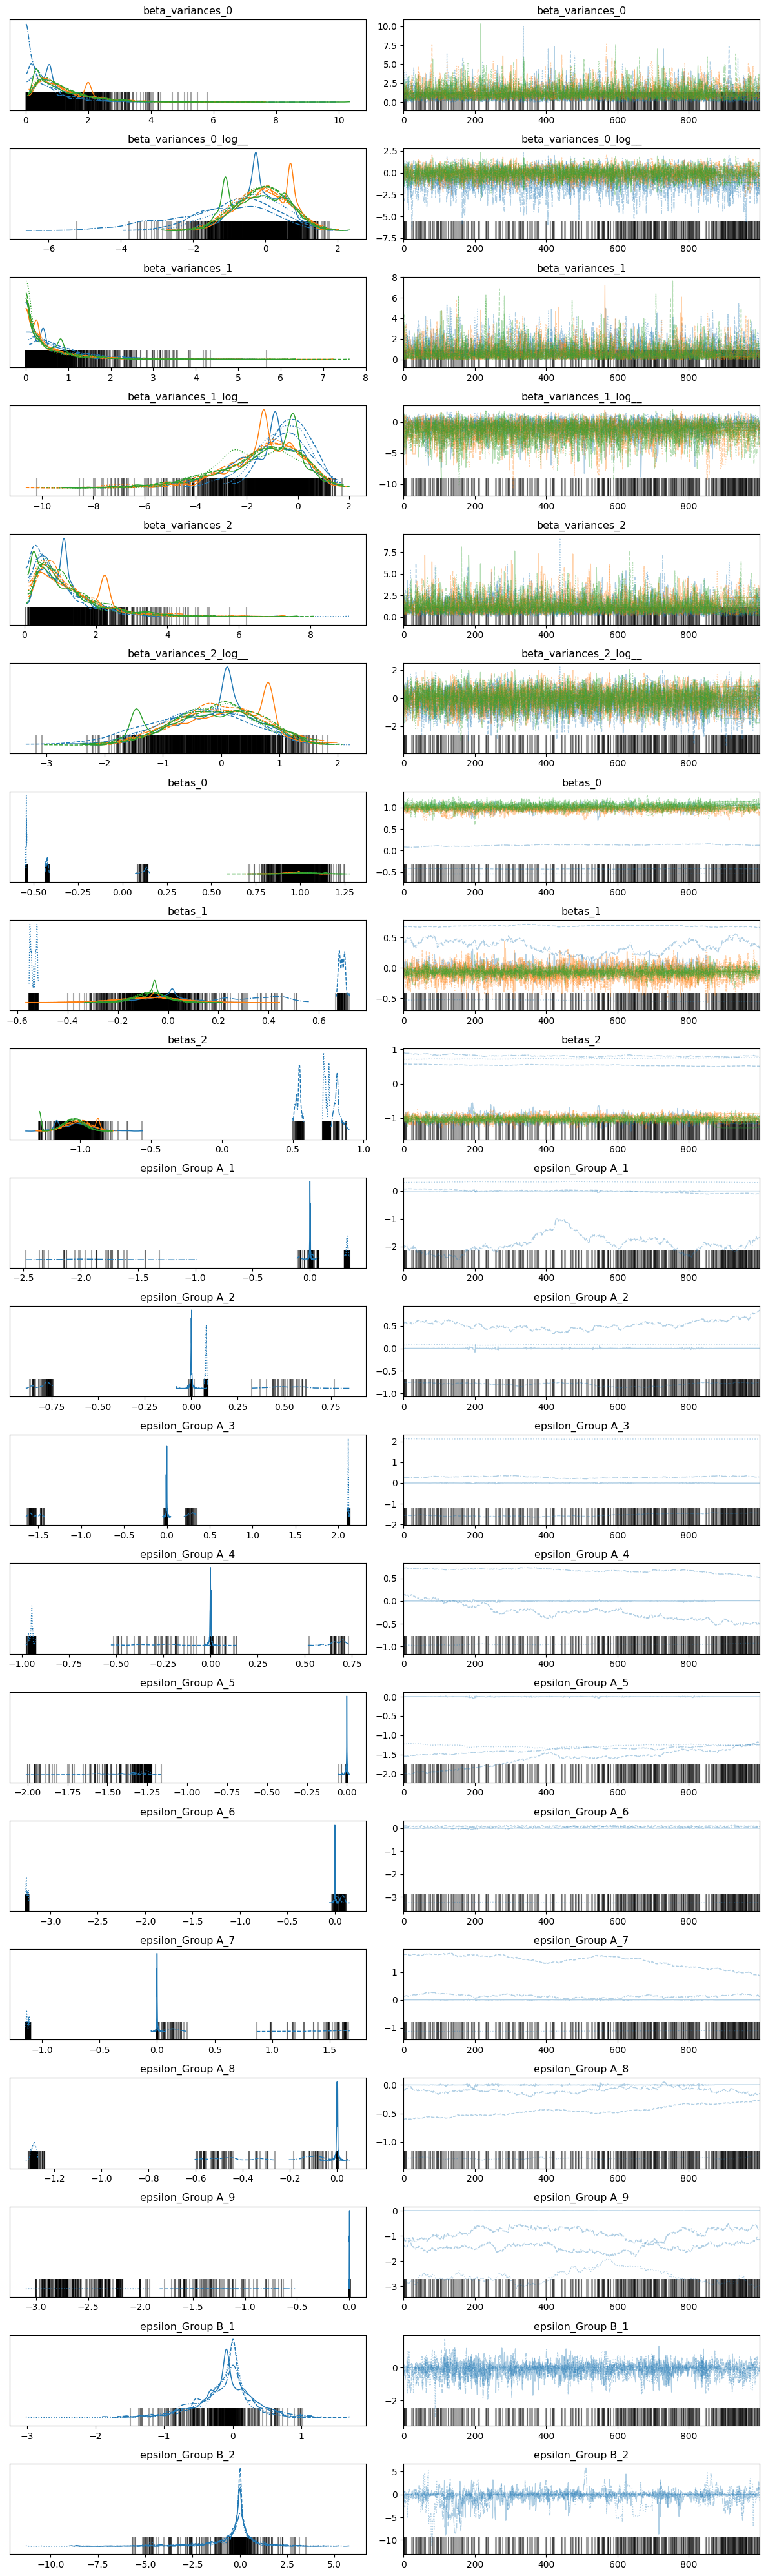

In [8]:
az.plot_trace(generalised_pareto_trace)
plt.tight_layout()

In [9]:
generalised_pareto_trace   

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).

In [10]:
with generalised_pareto_model:
    prior = pm.sample_prior_predictive()

Sampling: [beta_variances_0, beta_variances_1, beta_variances_2, betas_0, betas_1, betas_2, epsilon_Group A_1, epsilon_Group A_2, epsilon_Group A_3, epsilon_Group A_4, epsilon_Group A_5, epsilon_Group A_6, epsilon_Group A_7, epsilon_Group A_8, epsilon_Group A_9, epsilon_Group B_1, epsilon_Group B_2, epsilon_Group B_3, epsilon_Group B_4, epsilon_Group B_5, epsilon_Group B_6, epsilon_Group B_7, epsilon_Group B_8, epsilon_Group C_1, epsilon_Group C_10, epsilon_Group C_11, epsilon_Group C_2, epsilon_Group C_3, epsilon_Group C_4, epsilon_Group C_5, epsilon_Group C_6, epsilon_Group C_7, epsilon_Group C_8, epsilon_Group C_9, epsilon_sigma_Group A, epsilon_sigma_Group B, epsilon_sigma_Group C, gamma_Group A, gamma_Group B, gamma_Group C, initial_sigma_Group A, initial_sigma_Group B, initial_sigma_Group C, y_Group A_0, y_Group A_1, y_Group A_2, y_Group A_3, y_Group A_4, y_Group A_5, y_Group A_6, y_Group A_7, y_Group A_8, y_Group A_9, y_Group B_0, y_Group B_1, y_Group B_2, y_Group B_3, y_Group B

In [11]:
prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [12]:
with generalised_pareto_model:
    posterior = pm.sample_posterior_predictive(generalised_pareto_trace)

Sampling: [y_Group A_0, y_Group A_1, y_Group A_2, y_Group A_3, y_Group A_4, y_Group A_5, y_Group A_6, y_Group A_7, y_Group A_8, y_Group A_9, y_Group B_0, y_Group B_1, y_Group B_2, y_Group B_3, y_Group B_4, y_Group B_5, y_Group B_6, y_Group B_7, y_Group B_8, y_Group C_0, y_Group C_1, y_Group C_10, y_Group C_11, y_Group C_2, y_Group C_3, y_Group C_4, y_Group C_5, y_Group C_6, y_Group C_7, y_Group C_8, y_Group C_9]


Output()

In [13]:
posterior

Inference data with groups:
	> posterior_predictive
	> observed_data

In [14]:
from thesis_tools.utils.data import read_panel_data

In [15]:
read_panel_data()

,group,level_1,year,gdp_pc,MSCI,SPX,net_worth,N_net_worth,log_change_gdp_pc,log_change_MSCI,log_change_SPX
0,Alps,2449,2007,55761.563858,1515.400024,1438.239990,"[8.8, 5.5, 4.3, 3.6, 3.5, 3.4, 3.0, 2.7, 2.4, ...",10,NaN,NaN,NaN
1,Alps,3131,2008,62809.830445,1486.400024,1378.550049,"[10.3, 6.0, 5.2, 4.9, 4.0, 3.7, 3.7, 3.6, 3.2,...",14,0.119027,-0.019322,-0.042388
2,Alps,3929,2009,59594.137968,838.799988,825.880005,"[8.2, 5.7, 4.2, 3.7, 3.0, 2.9, 2.7, 2.7, 2.6, ...",12,-0.052554,-0.572140,-0.512338
3,Alps,4602,2010,61400.490911,1119.500000,1073.869995,"[10.0, 6.1, 4.4, 4.3, 4.1, 3.9, 3.3, 3.1, 3.0,...",15,0.029861,0.288665,0.262575
4,Alps,5530,2011,70551.454356,1331.699951,1286.119995,"[10.0, 6.4, 5.0, 4.8, 4.5, 4.0, 3.2, 2.9, 2.9,...",14,0.138924,0.173574,0.180361
...,...,...,...,...,...,...,...,...,...,...,...
343,U.S.,17579,2019,65120.394663,2029.599976,2704.100098,"[131.0, 96.5, 82.5, 62.5, 62.3, 55.5, 50.8, 50...",607,0.035912,-0.067579,-0.043318
344,U.S.,19550,2020,63528.634303,2342.399902,3225.520020,"[113.0, 98.0, 67.5, 59.0, 54.7, 54.6, 54.4, 54...",615,-0.024747,0.143337,0.176325
345,U.S.,21499,2021,70219.472454,2661.699951,3714.239990,"[177.0, 151.0, 124.0, 97.0, 96.0, 93.0, 91.5, ...",724,0.100135,0.127789,0.141080
346,U.S.,24074,2022,76329.582265,3052.500000,4515.549805,"[219.0, 171.0, 129.0, 118.0, 111.0, 107.0, 106...",735,0.083435,0.136996,0.195353
